# Time Series Imputation - Imputation with traditional methods

In this notebook, we explore how traditionally time-series are imputed. We will be exploring the impact of the different imputation methods depending on the lenght of the missing gap. 

The following imputation methods were explored: 
- Rolling Average and median
- Linear, quadratic and cubic interpolation
- `MICE` from `sklearn`

### Import the required packages

In [66]:
import numpy as np
import pandas as pd

from datetime import date

#import the imputation methods
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#import the scoring functions
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

### Auxiliary for imputation

In [36]:
# Imputation methods

def interpolation(df: pd.DataFrame, imp_cols: list, period = 1) -> pd.DataFrame:
    df_ = df.copy()
    # imputing using the rolling average, median and few interpolation techniques
    for c in imp_cols:
        df_[f"{c}_rolling_mean"] = df_[c].fillna(df_[c].rolling(period, min_periods=1,).mean()).ffill().bfill()
        df_[f"{c}_rolling_median"] = df_[c].fillna(df_[c].rolling(period, min_periods=1,).median()).ffill().bfill()
    
        df_[f"{c}_interp_lin"] = df_[c].interpolate(method='linear').ffill().bfill()
        df_[f"{c}_interp_quad"] = df_[c].interpolate(method='quadratic').ffill().bfill()
        df_[f"{c}_interp_cubic"] = df_[c].interpolate(method='cubic').ffill().bfill()
    return df_[[c for c in df_ if c not in df]]


def mice(df: pd.DataFrame, imp_cols:list , date_col = "Date") -> pd.DataFrame:
    X = df[imp_cols].to_numpy()
    imp = IterativeImputer()
    mice_df = imp.fit_transform(X)
    mice_df = pd.DataFrame(mice_df, columns=[f"{c}_mice" for c in df.columns if c != date_col])
    return mice_df

In [40]:
# Results evaluation

## Scores
def calc_r2score(df: pd.DataFrame, imp_cols: list):
    methods = ["rolling_mean", "rolling_median", "interp_lin", "interp_quad", "interp_cubic", "mice"]
    results = []
    for c in imp_cols:
        results.extend([(m, c, float(r2_score(df[c], df[f"{c}_{m}"]))) for m in methods])

    results_df = pd.DataFrame(np.array(results), columns=['Method', 'Col', 'R_squared'])
    results_df['R_squared'] = results_df['R_squared'].astype('float')
    
    return results_df

## Visualization
def plot_series(og_df: pd.DataFrame, missing_df: pd.DataFrame, imp_df: pd.DataFrame, cols:list, date_col='Date'):
    for c in cols:
        m = missing_df[c].isna()
        df_plot = og_df[m]

        col_interp_quad = f"{c}_interp_quad"
        interp_quad = imp_df[[date_col, col_interp_quad]][m]

        col_mice = f"{c}_mice"
        mice_d = imp_df[[date_col, col_mice]][m]

        plt.figure(figsize=[15, 5])
        plt.title(f"{c} over time")
        plt.plot(og_df['Date'], og_df[c], color="#040404", alpha=0.1, linewidth=1)

        plt.scatter(df_plot['Date'], df_plot[c], color="#E32212", marker='.', s=50, label="Original")
        plt.scatter(interp_quad['Date'], interp_quad[col_interp_quad], marker='.', s=50, label="Quadratic Interpolation")
        plt.scatter(mice_d['Date'], mice_d[col_mice], marker='x', s=50, label="MICE")

        plt.xlabel("Date")
        plt.ylabel(c)
        plt.xlim([date(2013, 1, 9), date(2013, 1, 12)])
        plt.ylim(-210, 200)
        plt.legend()
        plt.show()

### Read the data

In [21]:
og_df = pd.read_csv('spot_prices_oil.csv', index_col=[0])
og_df["Date"] = pd.to_datetime(og_df.Date, format="%Y-%m-%d %H:%M:%S")
og_df = og_df.sort_values('Date')

In [22]:
#read dataset with the short gaps
short_missing = pd.read_csv('missing_short.csv', index_col=[0])
short_missing["Date"] = pd.to_datetime(short_missing.Date, format="%Y-%m-%d %H:%M:%S")

In [23]:
#read dataset with the medium gaps
medium_missing = pd.read_csv('missing_medium.csv', index_col=[0])
medium_missing["Date"] = pd.to_datetime(medium_missing.Date, format="%Y-%m-%d %H:%M:%S")

In [24]:
#read dataset with the long gaps
long_missing = pd.read_csv('missing_long.csv', index_col=[0])
long_missing["Date"] = pd.to_datetime(long_missing.Date, format="%Y-%m-%d %H:%M:%S")

## Imputing the missing data

### Example medium gaps imputation

In [25]:
cols = [c for c in og_df.columns if c != 'Date']

In [31]:
#Impute with interpolation

inter_df = interpolation(medium_missing, imp_cols=cols, period=24)
inter_df.head(10)

,BE_rolling_mean,BE_rolling_median,BE_interp_lin,BE_interp_quad,BE_interp_cubic,DE_rolling_mean,DE_rolling_median,DE_interp_lin,DE_interp_quad,DE_interp_cubic,FR_rolling_mean,FR_rolling_median,FR_interp_lin,FR_interp_quad,FR_interp_cubic,NP_rolling_mean,NP_rolling_median,NP_interp_lin,NP_interp_quad,NP_interp_cubic
0,32.97,32.97,32.97,32.97,32.97,14.03,14.03,14.03,14.03,14.03,23.210,23.210,23.210,23.210,23.210,31.05,31.05,31.05,31.05,31.05
1,32.96,32.96,32.96,32.96,32.96,11.06,11.06,11.06,11.06,11.06,21.360,21.360,21.360,21.360,21.360,30.47,30.47,30.47,30.47,30.47
2,32.60,32.60,32.60,32.60,32.60,8.50,8.50,8.50,8.50,8.50,17.957,17.957,17.957,17.957,17.957,28.92,28.92,28.92,28.92,28.92
3,13.54,13.54,13.54,13.54,13.54,0.10,0.10,0.10,0.10,0.10,13.542,13.542,13.542,13.542,13.542,27.88,27.88,27.88,27.88,27.88
4,10.20,10.20,10.20,10.20,10.20,2.01,2.01,2.01,2.01,2.01,10.200,10.200,10.200,10.200,10.200,26.96,26.96,26.96,26.96,26.96
5,10.19,10.19,10.19,10.19,10.19,4.82,4.82,4.82,4.82,4.82,10.192,10.192,10.192,10.192,10.192,27.84,27.84,27.84,27.84,27.84
6,10.15,10.15,10.15,10.15,10.15,-0.07,-0.07,-0.07,-0.07,-0.07,10.151,10.151,10.151,10.151,10.151,28.79,28.79,28.79,28.79,28.79
7,10.04,10.04,10.04,10.04,10.04,3.95,3.95,3.95,3.95,3.95,10.042,10.042,10.042,10.042,10.042,28.63,28.63,28.63,28.63,28.63
8,11.94,11.94,11.94,11.94,11.94,11.94,11.94,11.94,11.94,11.94,11.944,11.944,11.944,11.944,11.944,28.44,28.44,28.44,28.44,28.44
9,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.153,12.153,12.153,12.153,12.153,28.30,28.30,28.30,28.30,28.30


In [33]:
#Impute with MICE

mice_df = mice(medium_missing, imp_cols=cols)

In [45]:
#concatening the different results
df_imputed = pd.concat([og_df, inter_df, mice_df], axis=1)

## Evaluating the imputation

In [50]:
results_df = calc_r2score(df_imputed, imp_cols=cols)
results_df

,Method,Col,R_squared
0,rolling_mean,BE,0.492403
1,rolling_median,BE,0.493109
2,interp_lin,BE,0.495527
3,interp_quad,BE,0.446751
4,interp_cubic,BE,0.437440
5,mice,BE,0.493402
6,rolling_mean,DE,0.478467
7,rolling_median,DE,0.478222
8,interp_lin,DE,0.476529
9,interp_quad,DE,0.284383


In [51]:
results_df.groupby(['Method']).mean().sort_values(by='R_squared', ascending=False)

/tmp/ipykernel_1962/204535436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby(['Method']).mean().sort_values(by='R_squared', ascending=False)


,R_squared
Method,
interp_lin,0.478611
rolling_median,0.477672
rolling_mean,0.477361
mice,0.476150
interp_cubic,0.400920
interp_quad,0.400162


In [55]:
def plot_series(missing_df: pd.DataFrame, imp_df: pd.DataFrame, imp_cols:list, date_col='Date'):
    for c in cols:
        m = missing_df[c].isna()
        df_plot = imp_df[m]

        col_interp_quad = f"{c}_interp_quad"
        interp_quad = df[[date_col, col_interp_quad]][m]

        col_mice = f"{c}_mice"
        mice_d = df[[date_col, col_mice]][m]

        plt.figure(figsize=[15, 5])
        plt.title(f"{c} over time")
        plt.plot(df['Date'], df[c], color="#040404", alpha=0.1, linewidth=1)

        plt.scatter(df_plot['Date'], df_plot[c], color="#E32212", marker='.', s=50, label="Original")
        plt.scatter(interp_quad['Date'], interp_quad[col_interp_quad], marker='.', s=50, label="Quadratic Interpolation")
        plt.scatter(mice_d['Date'], mice_d[col_mice], marker='x', s=50, label="MICE")

        plt.xlabel("Date")
        plt.ylabel(c)
        plt.xlim([date(2013, 1, 5), date(2013, 1, 15)])
        plt.ylim(-210, 200)
        plt.legend()
        plt.show()

/tmp/ipykernel_1962/3183533742.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = og_df[m]


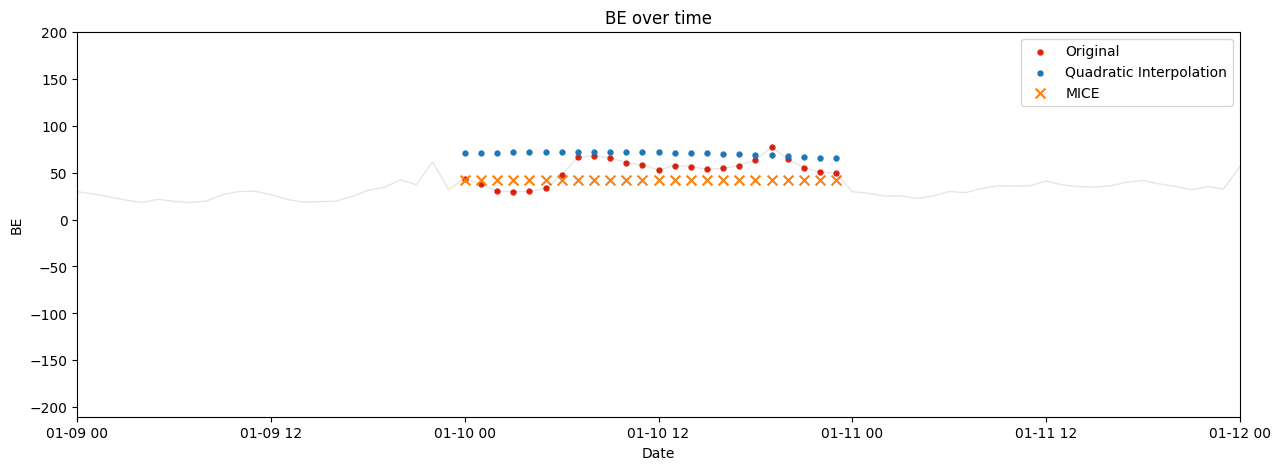

/tmp/ipykernel_1962/3183533742.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = og_df[m]


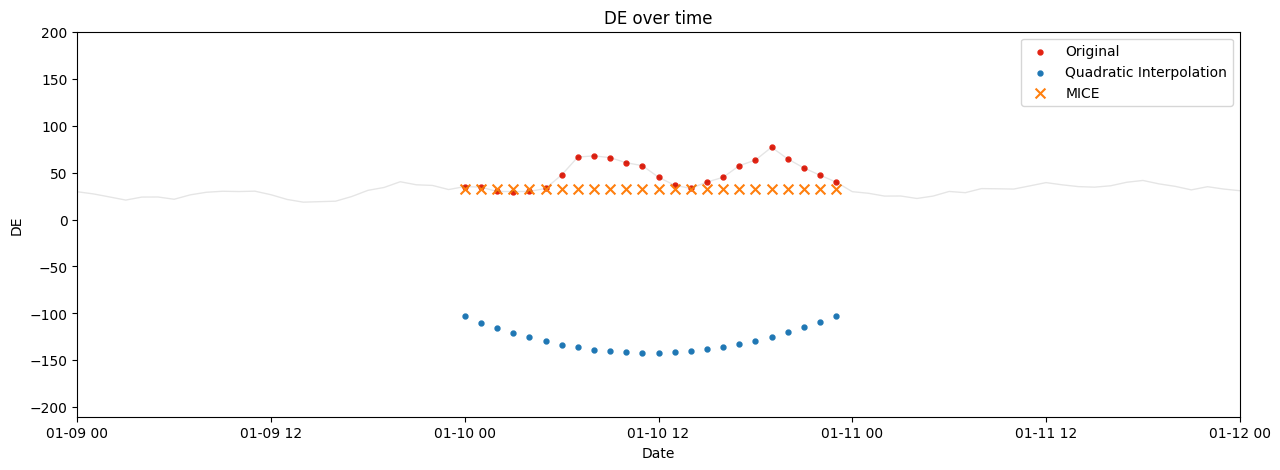

/tmp/ipykernel_1962/3183533742.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = og_df[m]


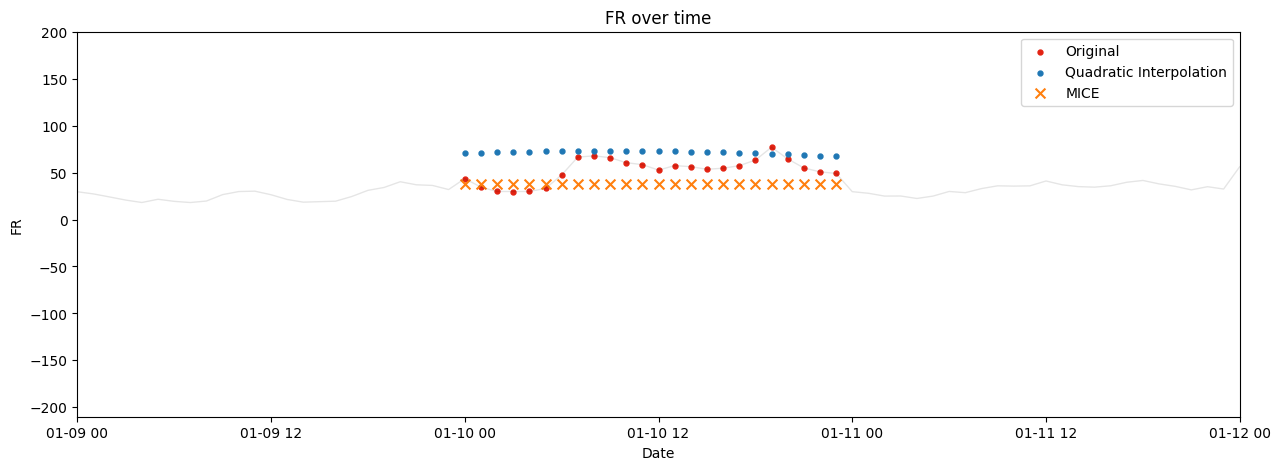

/tmp/ipykernel_1962/3183533742.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = og_df[m]


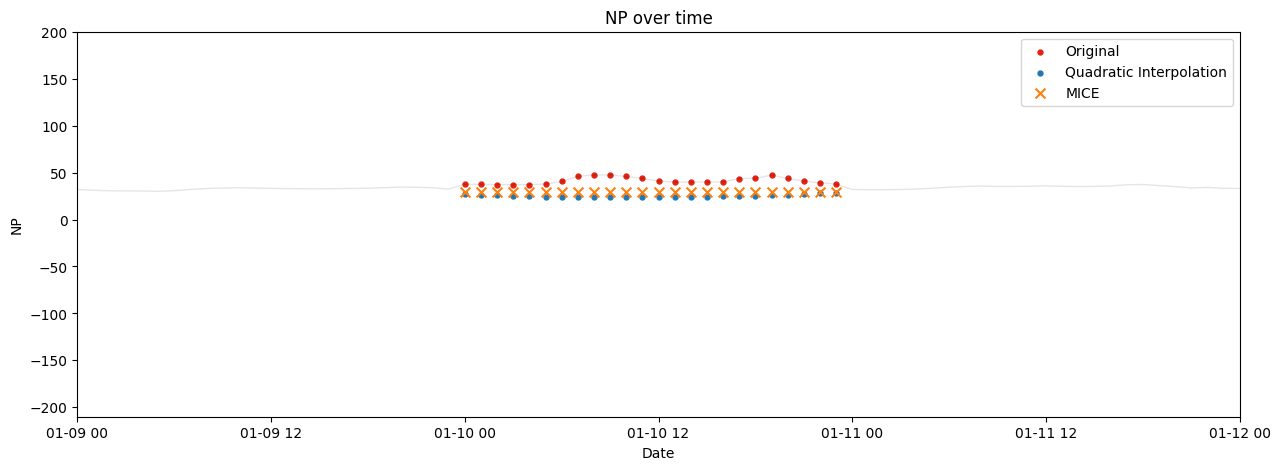

In [105]:
plot_series(og_df, medium_missing, df_imputed, cols)